In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf 

In [3]:
ds = pd.read_csv("adult.csv")
ds.replace('?', np.nan, inplace=True)
ds.dropna(inplace=True)

In [4]:
x=ds.iloc[:,:-1].values
y=ds.iloc[:,-1].values

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [6]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
x_train[:, 1:]=imputer.fit_transform(x_train[:,1:]) 

In [7]:
from sklearn.preprocessing import LabelEncoder

ordinal_categorical_columns = [1, 3, 5, 6, 7, 8, 9, 13]

label_encoders = []
for col_index in ordinal_categorical_columns:
    le = LabelEncoder()
    x_train[:, col_index] = le.fit_transform(x_train[:, col_index])
    x_test[:, col_index] = le.transform(x_test[:, col_index])
    label_encoders.append(le)

In [8]:
from sklearn.preprocessing import LabelEncoder
lb_obj= LabelEncoder() 
y_train=lb_obj.fit_transform(y_train)
y_test=lb_obj.transform(y_test)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
x_train_StandardScaled = scaler.fit_transform(x_train)
x_test_StandardScaled = scaler.transform(x_test)


In [10]:
ann_model=tf.keras.models.Sequential()

In [11]:
ann_model.add(tf.keras.layers.Dense(units=8,activation="relu"))

In [12]:
ann_model.add(tf.keras.layers.Dense(units=8,activation="relu"))

In [13]:
ann_model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

In [14]:
ann_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="binary_crossentropy",metrics=["accuracy"])

In [15]:
ann_model.fit(x_train_StandardScaled,y_train,batch_size=32,epochs=100)

Epoch 1/100


755/755 [==============================] - 3s 2ms/step - loss: 0.5383 - accuracy: 0.7327
Epoch 2/100
755/755 [==============================] - 1s 2ms/step - loss: 0.3748 - accuracy: 0.8278
Epoch 3/100
755/755 [==============================] - 1s 2ms/step - loss: 0.3515 - accuracy: 0.8364
Epoch 4/100
755/755 [==============================] - 1s 2ms/step - loss: 0.3410 - accuracy: 0.8405
Epoch 5/100
755/755 [==============================] - 2s 2ms/step - loss: 0.3355 - accuracy: 0.8431
Epoch 6/100
755/755 [==============================] - 1s 2ms/step - loss: 0.3323 - accuracy: 0.8439
Epoch 7/100
755/755 [==============================] - 1s 2ms/step - loss: 0.3306 - accuracy: 0.8436
Epoch 8/100
755/755 [==============================] - 1s 2ms/step - loss: 0.3295 - accuracy: 0.8440
Epoch 9/100
755/755 [==============================] - 1s 2ms/step - loss: 0.3286 - accuracy: 0.8449
Epoch 10/100
755/755 [==============================] - 1s 2ms/step - loss: 0.3279 - accuracy: 0.8451
E

In [16]:
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 120       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 201 (804.00 Byte)
Trainable params: 201 (804.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
print(ann_model.predict(scaler.transform([[0.177807, 0.088108,0.173244,1.218035,-0.036491,-0.407250,1.289114,-0.898177,0.394225,0.698654,-0.144749,-0.21852,0.851632,0.292299]]))> 0.5)

1/1 [==============================] - 0s 185ms/step
[[False]]


In [18]:
y_pred = ann_model.predict(x_test_StandardScaled)
y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

189/189 [==============================] - 0s 2ms/step
[[1 1]
 [1 0]
 [0 0]
 ...
 [0 0]
 [1 0]
 [1 0]]


In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8461793469252444

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import callbacks
from kerastuner.tuners import RandomSearch



# Define the model building function
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=4, max_value=64, step=4), activation='relu', input_shape=(x_train.shape[1],)))
    model.add(Dense(units=hp.Int('units_2', min_value=4, max_value=64, step=4), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Adjust the number of trials based on computational resources
    executions_per_trial=1,
    directory='ann_tuning',
    project_name='adult_dataset'
)

# Callback to stop training early if val_loss doesn't improve after a certain number of epochs
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform the hyperparameter search
tuner.search(x_train_StandardScaled, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

# Get the best model and print the summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Evaluate the best model on the test set
best_model.evaluate(x_test_StandardScaled, y_test)


Trial 5 Complete [00h 00m 22s]
val_accuracy: 0.8452134132385254

Best val_accuracy So Far: 0.8452134132385254
Total elapsed time: 00h 04m 24s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                180       
                                                                 
 dense_1 (Dense)             (None, 20)                260       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 461 (1.80 KB)
Trainable params: 461 (1.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
189/189 [==============================] - 1s 2ms/step - loss: 0.3369 - accuracy: 0.8455


[0.3368646204471588, 0.8455163240432739]

In [23]:
# Build the ANN model
ann_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=8, activation='relu', input_shape=(x_train_StandardScaled.shape[1],)),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(x_train_StandardScaled, y_train, batch_size=32, epochs=100, validation_split=0.1)

# Evaluate the model on test data
eval_results = ann_model.evaluate(x_test_StandardScaled, y_test)
print("Evaluation Results:", eval_results)


Epoch 1/100
679/679 [==============================] - 5s 4ms/step - loss: 0.4954 - accuracy: 0.7646 - val_loss: 0.3915 - val_accuracy: 0.8152
Epoch 2/100
679/679 [==============================] - 2s 3ms/step - loss: 0.3766 - accuracy: 0.8240 - val_loss: 0.3603 - val_accuracy: 0.8251
Epoch 3/100
679/679 [==============================] - 2s 3ms/step - loss: 0.3554 - accuracy: 0.8329 - val_loss: 0.3502 - val_accuracy: 0.8322
Epoch 4/100
679/679 [==============================] - 2s 3ms/step - loss: 0.3460 - accuracy: 0.8354 - val_loss: 0.3450 - val_accuracy: 0.8309
Epoch 5/100
679/679 [==============================] - 2s 3ms/step - loss: 0.3408 - accuracy: 0.8401 - val_loss: 0.3441 - val_accuracy: 0.8367
Epoch 6/100
679/679 [==============================] - 2s 3ms/step - loss: 0.3378 - accuracy: 0.8413 - val_loss: 0.3408 - val_accuracy: 0.8334
Epoch 7/100
679/679 [==============================] - 2s 3ms/step - loss: 0.3361 - accuracy: 0.8407 - val_loss: 0.3397 - val_accuracy: 0.8338

Epoch 1/100
679/679 [==============================] - 4s 3ms/step - loss: 0.4718 - accuracy: 0.7818 - val_loss: 0.3862 - val_accuracy: 0.8214
Epoch 2/100
679/679 [==============================] - 2s 3ms/step - loss: 0.3707 - accuracy: 0.8302 - val_loss: 0.3594 - val_accuracy: 0.8251
Epoch 3/100
679/679 [==============================] - 2s 3ms/step - loss: 0.3510 - accuracy: 0.8355 - val_loss: 0.3477 - val_accuracy: 0.8268
Epoch 4/100
679/679 [==============================] - 2s 3ms/step - loss: 0.3399 - accuracy: 0.8412 - val_loss: 0.3435 - val_accuracy: 0.8297
Epoch 5/100
679/679 [==============================] - 2s 3ms/step - loss: 0.3358 - accuracy: 0.8438 - val_loss: 0.3410 - val_accuracy: 0.8317
Epoch 6/100
679/679 [==============================] - 2s 3ms/step - loss: 0.3332 - accuracy: 0.8446 - val_loss: 0.3398 - val_accuracy: 0.8313
Epoch 7/100
679/679 [==============================] - 2s 3ms/step - loss: 0.3322 - accuracy: 0.8448 - val_loss: 0.3394 - val_accuracy: 0.8342

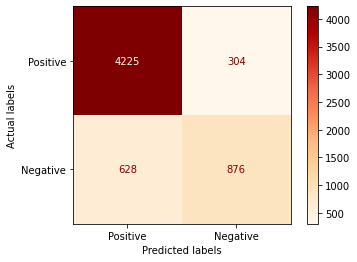

Accuracy: 0.8455163268688878
Recall: 0.5824468085106383
Precision: 0.7423728813559322
F1-score: 0.6527570789865872
189/189 [==============================] - 0s 2ms/step
AUC: 0.9014796195205367


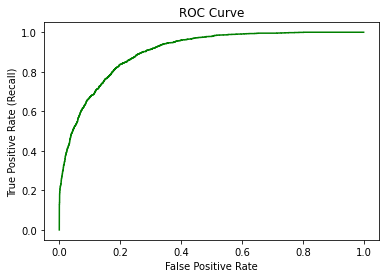

In [24]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Perform Standard Scaling if not already done
scaler = StandardScaler()
x_train_StandardScaled = scaler.fit_transform(x_train)
x_test_StandardScaled = scaler.transform(x_test)

# Build the ANN model
ann_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=8, activation='relu', input_shape=(x_train_StandardScaled.shape[1],)),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = ann_model.fit(x_train_StandardScaled, y_train, batch_size=32, epochs=100, validation_split=0.1)

# Predict on the test set using the trained ANN model
y_pred = (ann_model.predict(x_test_StandardScaled) > 0.5).astype("int32")

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])  # Replace with your class labels
disp.plot(cmap=plt.cm.OrRd)
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.show()

# Calculate and print the performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))  # By default, pos_label=1 for binary classification
print("Precision:", precision_score(y_test, y_pred))  # By default, pos_label=1 for binary classification
print("F1-score:", f1_score(y_test, y_pred))  # By default, pos_label=1 for binary classification

# Plotting the ROC curve and calculating the AUC
y_pred_prob = ann_model.predict(x_test_StandardScaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# Plot ROC curve
plt.plot(fpr, tpr, color='green')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()
